# Make predictions for Keras model ensemble and blend woth Pytorch model 

### The keras Unet model is based on the Kaggle kernel by 

## Load libraries and define system variables

In [1]:
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply

from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion
)

import pickle
import glob
import shutil
import os
import random
from PIL import Image

seed = 13
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
    
%matplotlib inline

Using TensorFlow backend.


In [2]:
# stage 2
INPUT_TEST_DIR_512='../input/512_s2/test'
# stage 1
#test_folder_512='../input/512/test'

WORK_DIR='../output/20190903_s2'

In [3]:
batch_size = 4
img_size = 512

## Defining Keras UEfficientNet Model

In [4]:
AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

In [5]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [6]:
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)

    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)
    
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [7]:
K.clear_session()

model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Test Set Predictions for Keras model: average over 5 folds with h-flip TTA

In [17]:
test_fn = glob.glob(INPUT_TEST_DIR_512+'/*')
x_test = [cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)

x_test_flipped = np.array([np.fliplr(x) for x in x_test]) # for tta

(3205, 512, 512, 3)


In [9]:
path_keras_models=[WORK_DIR+'/keras_swa_s2_512-4_f1.model',\
                   WORK_DIR+'/keras_swa_s2_512-3_f2.model',\
                   WORK_DIR+'/keras_swa_s2_512-3_f3.model',\
                   WORK_DIR+'/keras_swa_s2_512-4_f4.model',\
                   WORK_DIR+'/keras_swa_s2_512-4_f5.model']

In [11]:
for i in range(1,len(path_keras_models)+1): 
    model.load_weights(path_keras_models[i-1])

    if i==1:
        preds_test_orig = model.predict(x_test,batch_size=batch_size)
        preds_test_flipped = model.predict(x_test_flipped,batch_size=batch_size)
        preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])
        preds_test = 0.5*preds_test_orig + 0.5*preds_test_flipped
    else:
        preds_test_orig = model.predict(x_test,batch_size=batch_size)
        preds_test_flipped = model.predict(x_test_flipped,batch_size=batch_size)
        preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])
        preds_test = preds_test+0.5*preds_test_orig + 0.5*preds_test_flipped 
    print(i)
preds_test=preds_test/i


1
2
3
4
5


In [10]:
# save/load predictions to/from disk

with open(WORK_DIR+'/preds_test_keras_20190903_s2.pkl', 'wb') as f:
      pickle.dump(preds_test, f) 
        
# with open(WORK_DIR+'/preds_test_keras_20190903_s2.pkl', 'rb') as f:
#      preds_test=pickle.load(f)

## Plot Some Keras Test Set Predictions

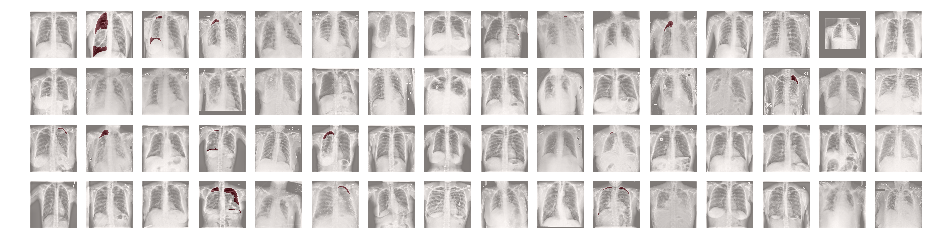

In [18]:
threshold_best = 0.55
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(index_val[:max_images]):
for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = preds_test[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Reds")
    ax.axis('off')

In [19]:
del x_test, x_test_flipped; gc.collect()

84404

In [20]:
del model; gc.collect()

912

## Load Previously Computed Pytorch Model Results

In [16]:
with open(WORK_DIR+'/probs_ave_1024.pkl', 'rb') as f:
     probs_py=pickle.load(f)

In [17]:
len(probs_py)

3205

In [16]:
np.shape(preds_test)

(3205, 512, 512, 1)

In [20]:
preds_test=preds_test.squeeze()
np.shape(preds_test)

(3205, 512, 512)

## Blend Keras & Pytorch models

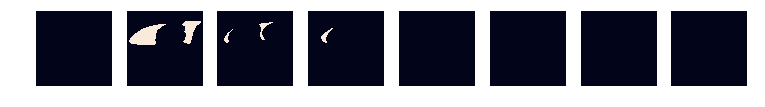

In [27]:
import sys
sys.path.insert(0, '../input')

from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for j in tqdm_notebook(range(np.shape(preds_test)[0])):
#      covert Pytorch images to the orginal size
    im = cv2.resize(preds_test[j],(1024,1024)) 
#      Blend Keras and Pytorch models as (3*Keras+1*Pytorch)/4.
    im=(3*im+probs_py[j])/4.
    im = im > threshold_best
#     zero out the small masks
    if im.sum()<3500:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [28]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head(10)

,ImageId,EncodedPixels
0,ID_743b284f8,-1
1,ID_ec235550f,146266 28 987 46 971 66 950 84 935 95 919 112 ...
2,ID_76747ee35,169692 14 998 30 984 42 975 49 962 62 956 68 9...
3,ID_71d2042e6,246096 6 1015 10 1011 13 1009 15 1007 17 1005 ...
4,ID_6023cb909,-1
5,ID_b439e7bb3,-1
6,ID_93ace8dc6,-1
7,ID_bf9328240,-1
8,ID_f9fa52a40,-1
9,ID_8a837104a,598138 3 1017 11 1011 16 10 8 989 37 985 40 98...


In [ ]:
plt.imshow(cv2.resize(preds_test[0].squeeze(),(1024,1024))>0.55)

In [29]:
sub_df.to_csv(WORK_DIR+'/submission_swa_512_5ave_0p55th_minpix3500_wpytorch0p25_stage2.csv', index=False)